In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from PIL import Image

import torch

import numpy as np
import matplotlib.pyplot as plt

from datasets import ring_dataset, randomized_ring_dataset, energy_randomized_ring_dataset
from models import DGBaNR, big_DGBaNR

Load dataset:

In [2]:
data_gen = energy_randomized_ring_dataset(N=32)
features, imgs = data_gen.generate_dataset(data_size=640000, seed=42, device='cpu', test_return=True)

KeyboardInterrupt: 

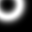

In [30]:
gaussian_ring, center, mean, sig = data_gen.gaussian_ring(1)
gaussian_ring, center, mean, sig = gaussian_ring[0], center[0], mean[0], sig[0]

features = torch.Tensor([[center[0], center[1], mean, sig, gaussian_ring.mean() * 32 * 32]])

Image.fromarray((gaussian_ring.reshape((32, 32)) * 255).astype(np.uint8))

Load generator:

In [34]:
generator = big_DGBaNR(data_gen.n_features, 32, 'sigmoid')
generator.load_state_dict(torch.load('../save_model/big_DGBaNR_sigmoid_energy_random_640000_64_Adam_mse_loss_1.pt', map_location=torch.device('cpu')))
generator.eval()

big_DGBaNR(
  (linear1): LinearReparameterization()
  (linear2): LinearReparameterization()
  (conv1): ConvTranspose2dReparameterization()
  (batch_norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2dReparameterization()
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2dReparameterization()
)

In [42]:
# setting the base feature
feature = [15, 15, 9.4, 3.6]
features = torch.Tensor(data_gen.scaler.transform(np.array([feature for i in range(1000)])))

# getting the predictions for this feature
with torch.no_grad():
    pred_rings = generator(features)[0].numpy().squeeze()
pred_ring = pred_rings.sum(axis=0)

# summing the predictions
pred_prob = pred_ring * 255 / pred_ring.max()
true_prob = data_gen.gaussian_from_features(*feature) * 255 / 1.3

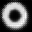

In [45]:
# predicted gaussian ring
Image.fromarray(pred_prob.astype(np.uint8))

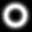

In [46]:
# true gaussian ring
Image.fromarray(true_prob.astype(np.uint8))

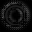

In [47]:
# difference between the rings
Image.fromarray(np.abs(true_prob - pred_prob).astype(np.uint8))

In [48]:
# relative error
print(np.abs(true_prob - pred_prob).mean() / prob.mean())

0.18116398695422897


In [5]:
np.arange(0.7, 1.3, 0.01).size

61

In [ ]:
# getting the distribution for one pmt
pmt = (7, 7)
pred_pmt_distr = pred_rings[:, pmt]
plt.hist(pred_pmt_distr, bins=60)

val = np.arange(-0.3, 0.3, 0.01) + true_prob[pmt]
true_pmt_distr = np.exp(-(val - 1)**2 / 0.2**2)
plt.plot(true_pmt_distr, val)
plt.show()